In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [2]:
df = pd.read_parquet('german_credit_data.parquet').drop('Unnamed: 0', axis=1)
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,None,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,None,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,None,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,None,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [3]:
df = df.rename(columns = {
    'Sex': 'Gender',
    'Saving accounts': 'Saving_acc',
    'Checking account': 'Checking_acc',
    'Credit amount': 'Credit_mnt',
})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Age           1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Job           1000 non-null   int64 
 3   Housing       1000 non-null   object
 4   Saving_acc    817 non-null    object
 5   Checking_acc  606 non-null    object
 6   Credit_mnt    1000 non-null   int64 
 7   Duration      1000 non-null   int64 
 8   Purpose       1000 non-null   object
 9   Risk          1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [5]:
df.describe()

,Age,Job,Credit_mnt,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [6]:
df.isna().sum()

Age               0
Gender            0
Job               0
Housing           0
Saving_acc      183
Checking_acc    394
Credit_mnt        0
Duration          0
Purpose           0
Risk              0
dtype: int64

In [7]:
df.Gender = df.Gender.apply(lambda x: 1 if x == 'male' else 0)
df.Risk = df.Risk.apply(lambda x: 1 if x == 'good' else 0)

In [8]:
def categorize(df, feature):
    cutted = pd.qcut(df[feature], 3, ['low', 'medium', 'high'])
    categorized = pd.DataFrame(cutted)
    df[feature] = categorized
    return df

In [9]:
def get_woe_map(df, feature, target):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad
        
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Distribution Good'] = (
        (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    )
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})


    data = data.sort_values(by='WoE')
    data.index = range(len(data.index))
    data = data.set_index('Value')['WoE'].to_dict()
    
    return data

In [10]:
categorize(df, 'Age')
woe_map = get_woe_map(df, 'Age', 'Risk')
df.Age = df.Age.map(woe_map)

In [11]:
categorize(df, 'Duration')
woe_map = get_woe_map(df, 'Duration', 'Risk')
df.Duration = df.Duration.map(woe_map)

In [12]:
categorize(df, 'Credit_mnt')
woe_map = get_woe_map(df, 'Credit_mnt', 'Risk')
df.Credit_mnt = df.Credit_mnt.map(woe_map)

In [13]:
df

,Age,Gender,Job,Housing,Saving_acc,Checking_acc,Credit_mnt,Duration,Purpose,Risk
0,-0.185717,1,2,own,None,little,-0.075289,-0.467416,radio/TV,1
1,0.294733,0,2,own,little,moderate,0.286502,0.620240,radio/TV,0
2,-0.185717,1,1,own,little,None,-0.239338,-0.467416,education,1
3,-0.185717,1,2,free,little,little,0.286502,0.620240,furniture/equipment,1
4,-0.185717,1,2,free,little,little,0.286502,-0.015108,car,0
...,...,...,...,...,...,...,...,...,...,...
995,-0.138836,0,1,own,little,None,-0.239338,-0.467416,furniture/equipment,1
996,-0.185717,1,3,own,little,little,0.286502,0.620240,car,1
997,-0.138836,1,2,own,little,None,-0.075289,-0.467416,radio/TV,1
998,0.294733,1,2,free,little,little,-0.239338,0.620240,radio/TV,0


In [14]:
woe_map = get_woe_map(df, 'Job', 'Risk')
df.Job = df.Job.map(woe_map)

In [15]:
woe_map = get_woe_map(df, 'Housing', 'Risk')
df.Housing = df.Housing.map(woe_map)

In [16]:
df.Saving_acc = df.Saving_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'quite rich': 'high',
    'rich': 'high'
})

In [17]:
woe_map = get_woe_map(df, 'Saving_acc', 'Risk')
df.Saving_acc = df.Saving_acc.map(woe_map)

In [18]:
df.Checking_acc = df.Checking_acc.map({
    None: 'none',
    'little': 'low',
    'moderate': 'medium',
    'rich': 'high'
})

In [19]:
woe_map = get_woe_map(df, 'Checking_acc', 'Risk')
df.Checking_acc = df.Checking_acc.map(woe_map)

In [20]:
df.Purpose = df.Purpose.str.replace('/', '_').str.replace(' ', '_')

In [21]:
woe_map = get_woe_map(df, 'Purpose', 'Risk')
df.Purpose = df.Purpose.map(woe_map)

In [22]:
df

,Age,Gender,Job,Housing,Saving_acc,Checking_acc,Credit_mnt,Duration,Purpose,Risk
0,-0.185717,1,-0.022780,-0.194156,-0.704246,0.818099,-0.075289,-0.467416,-0.410063,1
1,0.294733,0,-0.022780,-0.194156,0.271358,0.401392,0.286502,0.620240,-0.410063,0
2,-0.185717,1,-0.097164,-0.194156,0.271358,-1.176263,-0.239338,-0.467416,0.399273,1
3,-0.185717,1,-0.022780,0.472604,0.271358,0.818099,0.286502,0.620240,0.095557,1
4,-0.185717,1,-0.022780,0.472604,0.271358,0.818099,0.286502,-0.015108,0.068319,0
...,...,...,...,...,...,...,...,...,...,...
995,-0.138836,0,-0.097164,-0.194156,0.271358,-1.176263,-0.239338,-0.467416,0.095557,1
996,-0.185717,1,0.204413,-0.194156,0.271358,0.818099,0.286502,0.620240,0.068319,1
997,-0.138836,1,-0.022780,-0.194156,0.271358,-1.176263,-0.075289,-0.467416,-0.410063,1
998,0.294733,1,-0.022780,0.472604,0.271358,0.818099,-0.239338,0.620240,-0.410063,0


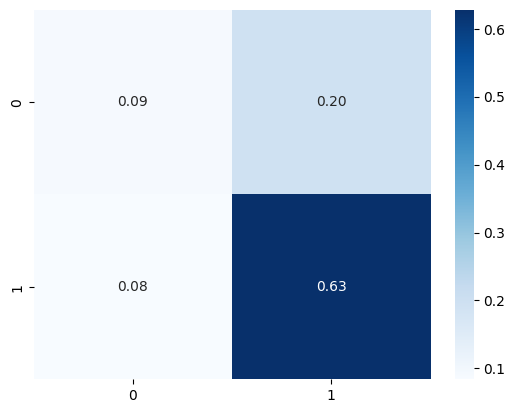

Accuracy score:  0.72
F1 score:        0.82
Precision score: 0.76
Recall score:    0.88


In [23]:
y = df.Risk
X = df.loc[:, df.columns != 'Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

sns.heatmap(
    metrics.confusion_matrix(y_test, y_predicted, normalize='all'),
    cmap='Blues', annot=True, fmt='.2f'
)
plt.show()

print('Accuracy score:  {:.2f}'.format( metrics.accuracy_score(y_test, y_predicted) ))
print('F1 score:        {:.2f}'.format( metrics.f1_score(y_test, y_predicted) ))
print('Precision score: {:.2f}'.format( metrics.precision_score(y_test, y_predicted) ))
print('Recall score:    {:.2f}'.format( metrics.recall_score(y_test, y_predicted) ))